# STIMP, MaskedAE and Lin-itp

In [1]:
import torch
import numpy as np 
import sys
import os
from dataset.dataset_imputation import PRE8dDataset

In [2]:
import argparse
parser = argparse.ArgumentParser(description='Imputation')

# args for area and methods
parser.add_argument('--area', type=str, default='PRE', help='which bay area we focus')

# basic args
parser.add_argument('--epochs', type=int, default=500, help='epochs')
parser.add_argument('--batch_size', type=int, default=16, help='batch size')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')
parser.add_argument('--wd', type=float, default=1e-4, help='weight decay')
parser.add_argument('--test_freq', type=int, default=500, help='test per n epochs')
parser.add_argument('--embedding_size', type=int, default=32)
parser.add_argument('--hidden_channels', type=int, default=32)
parser.add_argument('--diffusion_embedding_size', type=int, default=64)
parser.add_argument('--side_channels', type=int, default=1)

# args for tasks
parser.add_argument('--in_len', type=int, default=46)
parser.add_argument('--out_len', type=int, default=46)
parser.add_argument('--missing_ratio', type=float, default=0.1)

# args for diffusion
parser.add_argument('--beta_start', type=float, default=0.0001, help='beta start from this')
parser.add_argument('--beta_end', type=float, default=0.2, help='beta end to this')
parser.add_argument('--num_steps', type=float, default=50, help='denoising steps')
parser.add_argument('--num_samples', type=int, default=10, help='n datasets')
parser.add_argument('--schedule', type=str, default='quad', help='noise schedule type')
parser.add_argument('--target_strategy', type=str, default='random', help='mask')

# args for mae
parser.add_argument('--num_heads', type=int, default=8, help='n heads for self attention')
config = parser.parse_args([])

**Fig 3a**

In [3]:
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

# load model
model = torch.load("./log_bak/imputation/PRE/STIMP/best_0.1.pt")
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [17]:
mae = torch.load("./log_bak/imputation/PRE/MAE/best.pt")
is_sea = np.load("./data/{}/is_sea.npy".format(config.area))
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)


In [18]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

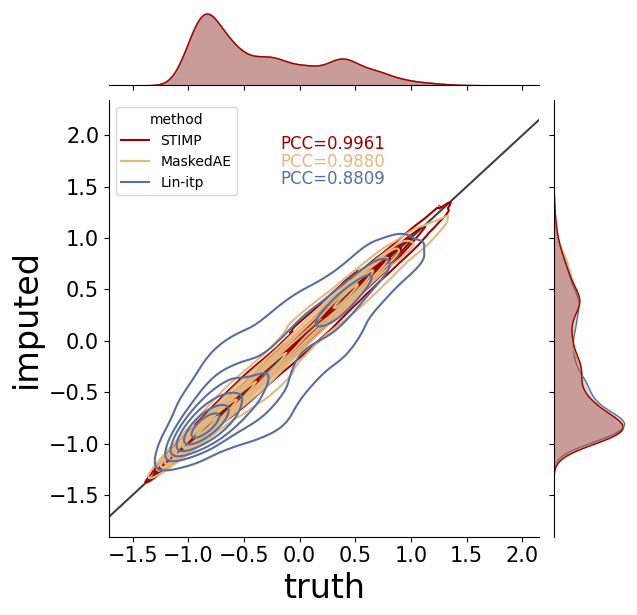

In [19]:
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_mae = imputed_mae[:]
imputed_itp = imputed_itp[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['MaskedAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-itp' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_mae.cpu().detach().numpy()).statistic.item()
pcc3=stat.pearsonr(truth[:], imputed_itp).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#e3b87f")
plt.text(0.40, 0.84, 'PCC={:.4f}'.format(pcc3), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [20]:
config.missing_ratio=0.5
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

model = torch.load("./log_bak/imputation/PRE/STIMP/best_0.5.pt")
model = model.to(device)
cond_mask = data_gt_masks
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [21]:
mae = torch.load("./log_bak/imputation/PRE/MAE/best_0.5.pt")
is_sea = np.load("./data/{}/is_sea.npy".format(config.area))
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)

In [22]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

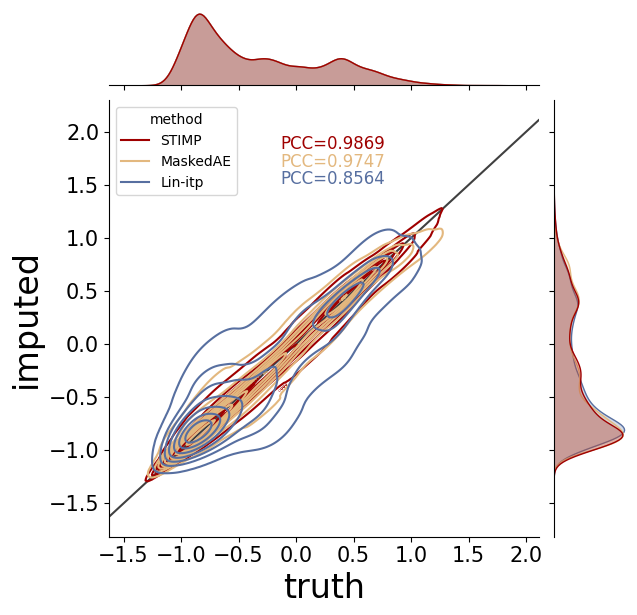

In [23]:
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_mae = imputed_mae[:]
imputed_itp = imputed_itp[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['MaskedAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-itp' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_mae.cpu().detach().numpy()).statistic.item()
pcc3=stat.pearsonr(truth[:], imputed_itp).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#e3b87f")
plt.text(0.40, 0.84, 'PCC={:.4f}'.format(pcc3), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [24]:
config.missing_ratio=0.9
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)
model = torch.load("./log/imputation/PRE/STIMP/best_0.9.pt")
model = model.to(device)
cond_mask = data_gt_masks
imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [25]:
mae = torch.load("./log_bak/imputation/PRE/MAE/best_0.9.pt")
is_sea = np.load("./data/{}/is_sea.npy".format(config.area))
datas_image = torch.zeros(1,46,1,60,96)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,60,96)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)

In [26]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

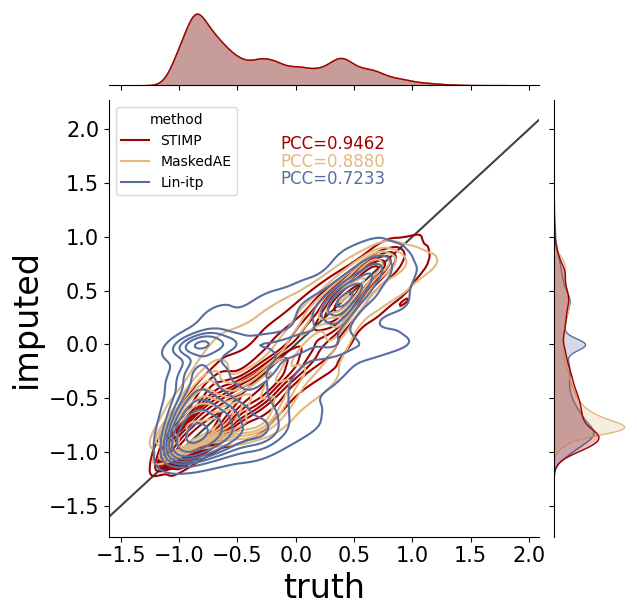

In [27]:
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_mae = imputed_mae[:]
imputed_itp = imputed_itp[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['MaskedAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-itp' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_mae.cpu().detach().numpy()).statistic.item()
pcc3=stat.pearsonr(truth[:], imputed_itp).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#e3b87f")
plt.text(0.40, 0.84, 'PCC={:.4f}'.format(pcc3), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [58]:
config.area = "MEXICO"
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

# load model
model = torch.load("./log_bak/imputation/{}/STIMP/best_0.1.pt".format(config.area))
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [59]:
mae = torch.load("./log_bak/imputation/{}/MAE/best.pt".format(config.area))
is_sea = np.load("./data/{}/is_sea.npy".format(config.area))
H, W = is_sea.shape
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)

In [60]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

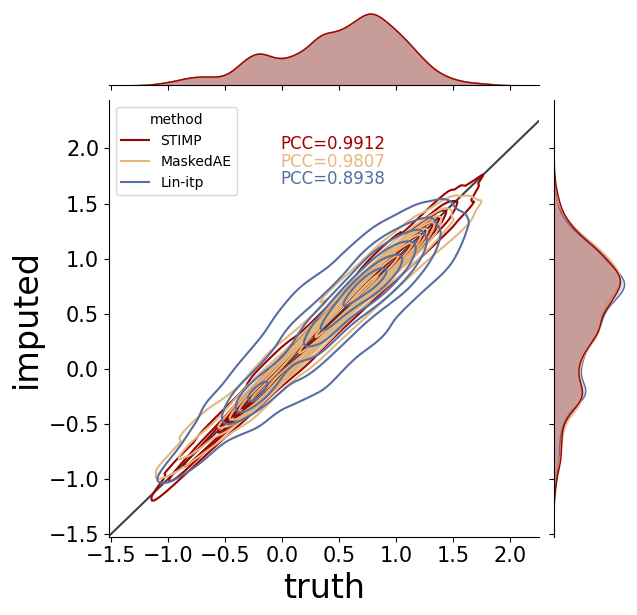

In [61]:
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_mae = imputed_mae[:]
imputed_itp = imputed_itp[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['MaskedAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-itp' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_mae.cpu().detach().numpy()).statistic.item()
pcc3=stat.pearsonr(truth[:], imputed_itp).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#e3b87f")
plt.text(0.40, 0.84, 'PCC={:.4f}'.format(pcc3), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [67]:
config.missing_ratio=0.5
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

# load model
model = torch.load("./log_bak/imputation/{}/STIMP/best_0.5.pt".format(config.area))
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [65]:
mae = torch.load("./log_bak/imputation/{}/MAE/best_0.5.pt".format(config.area))
is_sea = np.load("./data/{}/is_sea.npy".format(config.area))
H, W = is_sea.shape
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)

In [64]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

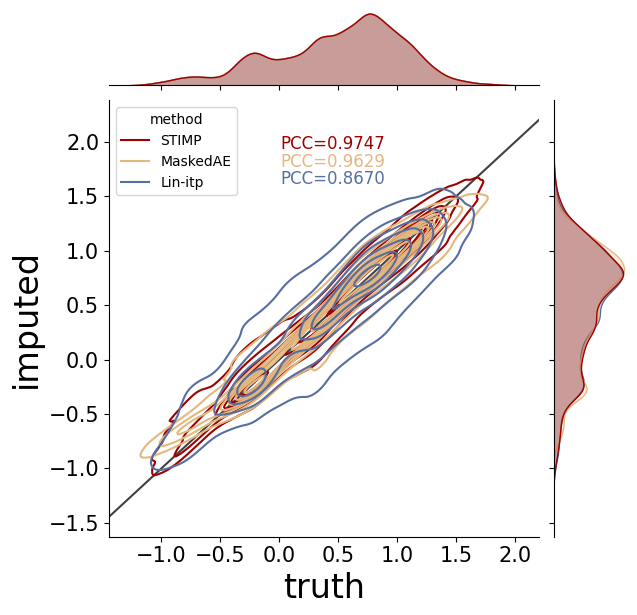

In [66]:
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_mae = imputed_mae[:]
imputed_itp = imputed_itp[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['MaskedAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-itp' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_mae.cpu().detach().numpy()).statistic.item()
pcc3=stat.pearsonr(truth[:], imputed_itp).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#e3b87f")
plt.text(0.40, 0.84, 'PCC={:.4f}'.format(pcc3), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [68]:
config.missing_ratio=0.9
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

# load model
model = torch.load("./log_bak/imputation/{}/STIMP/best_0.9.pt".format(config.area))
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [69]:
mae = torch.load("./log_bak/imputation/{}/MAE/best_0.9.pt".format(config.area))
is_sea = np.load("./data/{}/is_sea.npy".format(config.area))
H, W = is_sea.shape
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)

In [70]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

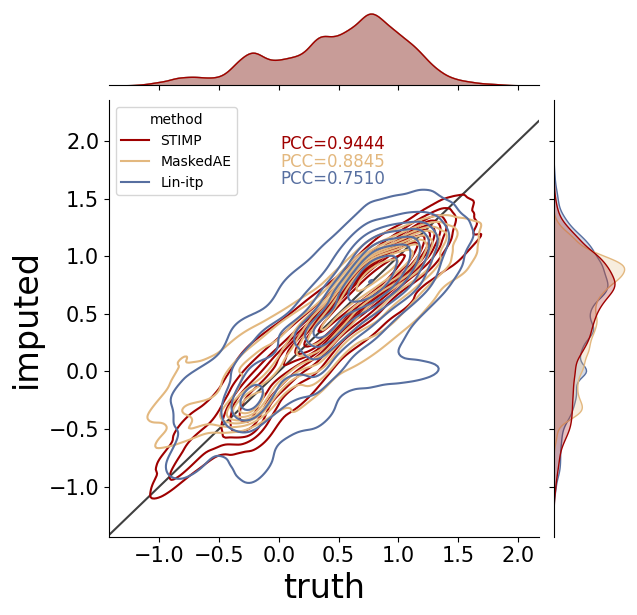

In [71]:
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_mae = imputed_mae[:]
imputed_itp = imputed_itp[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['MaskedAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-itp' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_mae.cpu().detach().numpy()).statistic.item()
pcc3=stat.pearsonr(truth[:], imputed_itp).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#e3b87f")
plt.text(0.40, 0.84, 'PCC={:.4f}'.format(pcc3), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [88]:
config.area = "Chesapeake"
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

# load model
model = torch.load("./log_bak/imputation/{}/STIMP/best_0.1.pt".format(config.area))
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [89]:
mae = torch.load("./log_bak/imputation/{}/MAE/best.pt".format(config.area))
is_sea = np.load("./data/{}/is_sea.npy".format(config.area))
H, W = is_sea.shape
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)

In [90]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

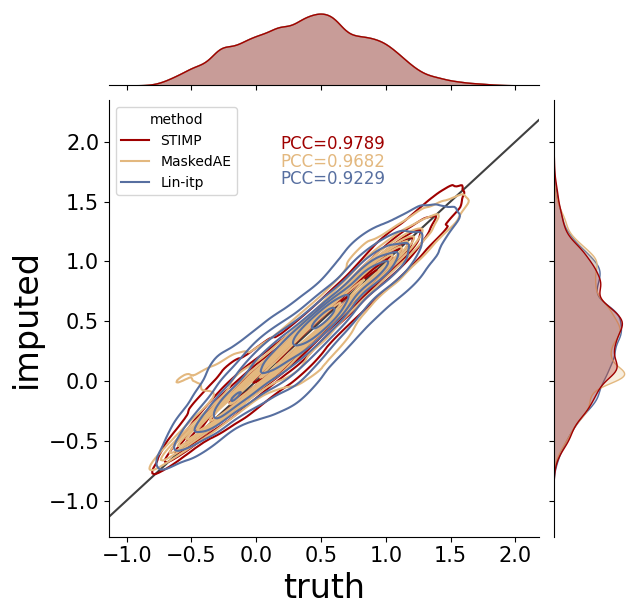

In [91]:
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_mae = imputed_mae[:]
imputed_itp = imputed_itp[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['MaskedAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-itp' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_mae.cpu().detach().numpy()).statistic.item()
pcc3=stat.pearsonr(truth[:], imputed_itp).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#e3b87f")
plt.text(0.40, 0.84, 'PCC={:.4f}'.format(pcc3), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [84]:
config.missing_ratio=0.5
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

# load model
model = torch.load("./log_bak/imputation/{}/STIMP/best_0.5.pt".format(config.area))
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [85]:
mae = torch.load("./log_bak/imputation/{}/MAE/best_0.5.pt".format(config.area))
is_sea = np.load("./data/{}/is_sea.npy".format(config.area))
H, W = is_sea.shape
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)

In [86]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

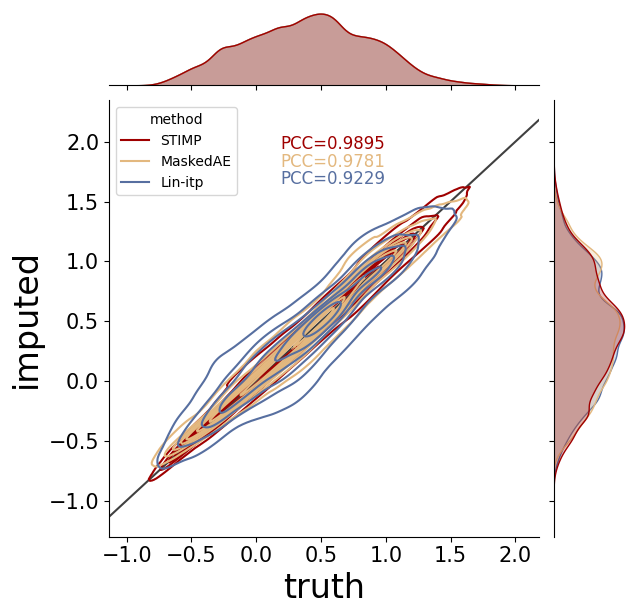

In [87]:
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_mae = imputed_mae[:]
imputed_itp = imputed_itp[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['MaskedAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-itp' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_mae.cpu().detach().numpy()).statistic.item()
pcc3=stat.pearsonr(truth[:], imputed_itp).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#e3b87f")
plt.text(0.40, 0.84, 'PCC={:.4f}'.format(pcc3), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [80]:
config.missing_ratio=0.9
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

# load model
model = torch.load("./log_bak/imputation/{}/STIMP/best_0.9.pt".format(config.area))
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [81]:
mae = torch.load("./log_bak/imputation/{}/MAE/best_0.9.pt".format(config.area))
is_sea = np.load("./data/{}/is_sea.npy".format(config.area))
H, W = is_sea.shape
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)

In [82]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

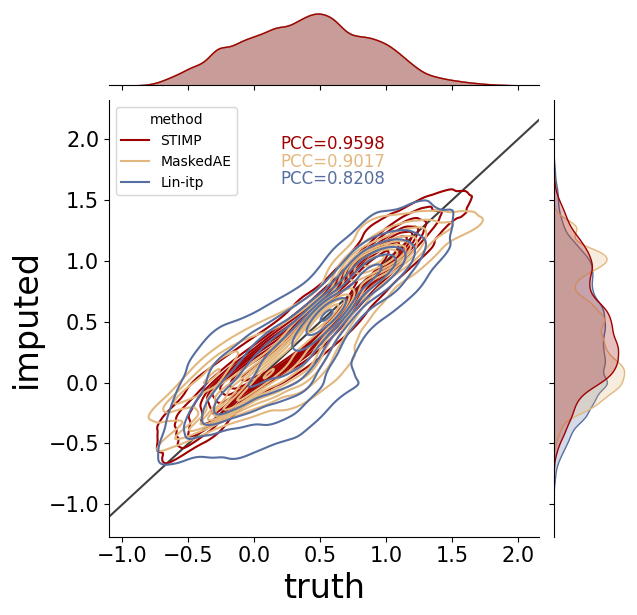

In [83]:
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_mae = imputed_mae[:]
imputed_itp = imputed_itp[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['MaskedAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-itp' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_mae.cpu().detach().numpy()).statistic.item()
pcc3=stat.pearsonr(truth[:], imputed_itp).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#e3b87f")
plt.text(0.40, 0.84, 'PCC={:.4f}'.format(pcc3), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [92]:
config.area = "Yangtze"
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

# load model
model = torch.load("./log_bak/imputation/{}/STIMP/best_0.1.pt".format(config.area))
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [93]:
mae = torch.load("./log_bak/imputation/{}/MAE/best.pt".format(config.area))
is_sea = np.load("./data/{}/is_sea.npy".format(config.area))
H, W = is_sea.shape
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)

In [94]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

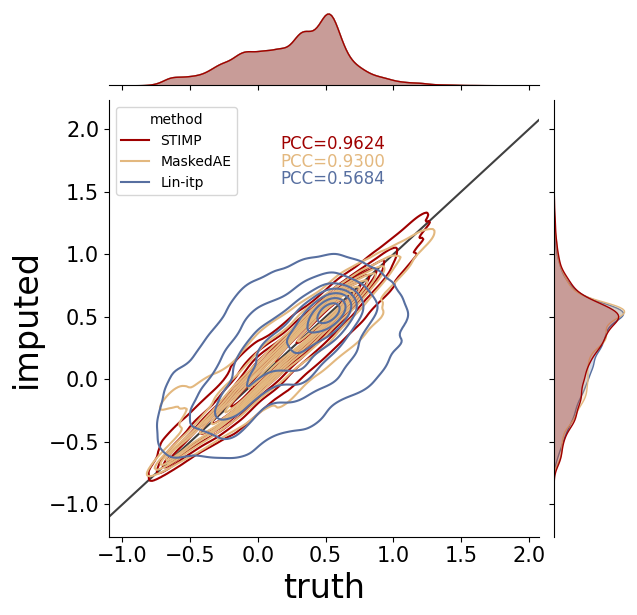

In [95]:
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_mae = imputed_mae[:]
imputed_itp = imputed_itp[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['MaskedAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-itp' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_mae.cpu().detach().numpy()).statistic.item()
pcc3=stat.pearsonr(truth[:], imputed_itp).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#e3b87f")
plt.text(0.40, 0.84, 'PCC={:.4f}'.format(pcc3), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [96]:
config.missing_ratio=0.5
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

# load model
model = torch.load("./log_bak/imputation/{}/STIMP/best_0.5.pt".format(config.area))
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [97]:
mae = torch.load("./log_bak/imputation/{}/MAE/best_0.5.pt".format(config.area))
is_sea = np.load("./data/{}/is_sea.npy".format(config.area))
H, W = is_sea.shape
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)

In [98]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

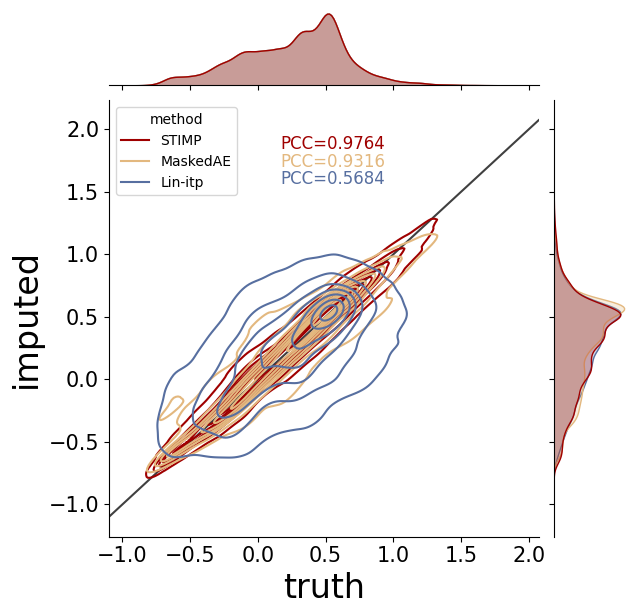

In [99]:
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_mae = imputed_mae[:]
imputed_itp = imputed_itp[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['MaskedAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-itp' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_mae.cpu().detach().numpy()).statistic.item()
pcc3=stat.pearsonr(truth[:], imputed_itp).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#e3b87f")
plt.text(0.40, 0.84, 'PCC={:.4f}'.format(pcc3), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [100]:
config.missing_ratio=0.9
from torch.utils.data import DataLoader
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
device = "cuda"
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

# load model
model = torch.load("./log_bak/imputation/{}/STIMP/best_0.9.pt".format(config.area))
model = model.to(device)
cond_mask = data_gt_masks
adj = np.load("./data/{}/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)

imputed_data_our = model.impute(datas, cond_mask, adj, 10)
imputed_data_our = imputed_data_our.median(1).values
mask = data_ob_masks - cond_mask
imputed_our = imputed_data_our[0][mask.bool().cpu()[0]]
truth = datas[0][mask.bool()[0]].cpu()

In [101]:
mae = torch.load("./log_bak/imputation/{}/MAE/best_0.9.pt".format(config.area))
is_sea = np.load("./data/{}/is_sea.npy".format(config.area))
H, W = is_sea.shape
datas_image = torch.zeros(1,46,1,H,W)
datas_image = datas_image.to(device)
datas_image[:,:,:,is_sea.astype(bool)]=datas
cond_mask_image = torch.zeros(1,46,1,H,W)
cond_mask_image = cond_mask_image.to(device)
cond_mask_image[:,:,:,is_sea.astype(bool)]=cond_mask
imputed_data_mae = mae.impute(datas_image, cond_mask_image)

In [102]:
from einops import rearrange
import torchcde
tmp_data = torch.where(cond_mask.cpu()==0, float("nan"), datas.cpu())
tmp_data = rearrange(tmp_data, "b t c n-> (b n) t c")
itp_data = torchcde.linear_interpolation_coeffs(tmp_data)
imputed_data_itp = rearrange(itp_data, "(b n) t c -> b t c n", b=datas.shape[0], n=datas.shape[-1])

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

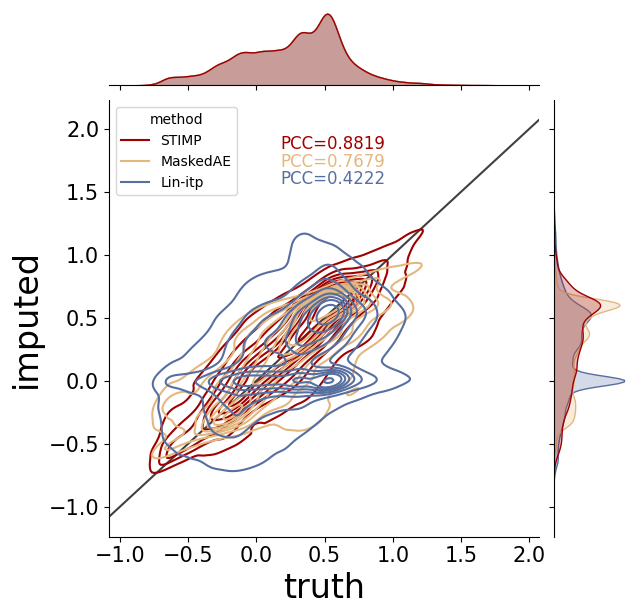

In [103]:
imputed_data_mae = imputed_data_mae[:,:,:,is_sea.astype(bool)]
imputed_mae = imputed_data_mae[0][mask.bool().cpu()[0]]
imputed_itp = imputed_data_itp[0][mask.bool().cpu()[0]]
imputed_our = imputed_our[:]
imputed_mae = imputed_mae[:]
imputed_itp = imputed_itp[:]
truth = truth[:]

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import pandas as pd
method = []
method.extend(['STIMP' for i in range(imputed_our.shape[0])])
method.extend(['MaskedAE' for i in range(imputed_our.shape[0])])
method.extend(['Lin-itp' for i in range(imputed_our.shape[0])])
data = {'truth': np.concatenate([truth.numpy() for i in range(3)]),
        'imputed':np.concatenate([imputed_our.numpy(), imputed_mae.cpu().detach().numpy(), imputed_itp.numpy()]),
        'method':method}
data = pd.DataFrame.from_dict(data)
color =["#9F0000","#e3b87f","#576fa0"]
g=sns.jointplot(data=data, x="truth", y="imputed", hue="method", kind='kde', palette=color, marginal_kws={'common_norm':False,'shade':True})
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, 'k-', alpha=0.75, zorder=0)
plt.ylabel("imputed", size=24)
plt.xlabel("truth", size=24)
pcc1=stat.pearsonr(truth[:], imputed_our).statistic.item()
pcc2=stat.pearsonr(truth[:], imputed_mae.cpu().detach().numpy()).statistic.item()
pcc3=stat.pearsonr(truth[:], imputed_itp).statistic.item()
plt.text(0.40, 0.92, 'PCC={:.4f}'.format(pcc1), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#9F0000")
plt.text(0.40, 0.88, 'PCC={:.4f}'.format(pcc2), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#e3b87f")
plt.text(0.40, 0.84, 'PCC={:.4f}'.format(pcc3), transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color="#576fa0")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)